In [16]:
from IPython import get_ipython


def type_of_script():
    """
    Detects and returns the type of python kernel
    :return: string 'jupyter' or 'ipython' or 'terminal'
    """
    try:
        ipy_str = str(type(get_ipython()))
        if 'zmqshell' in ipy_str:
            return 'jupyter'
        if 'terminal' in ipy_str:
            return 'ipython'
    except:
        return 'terminal'


if type_of_script() == 'jupyter':
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm
    
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
import cmasher as cmr

import numpy as np
import os, glob, atexit, signal
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle, ax_change_color
from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value
from common_func import *

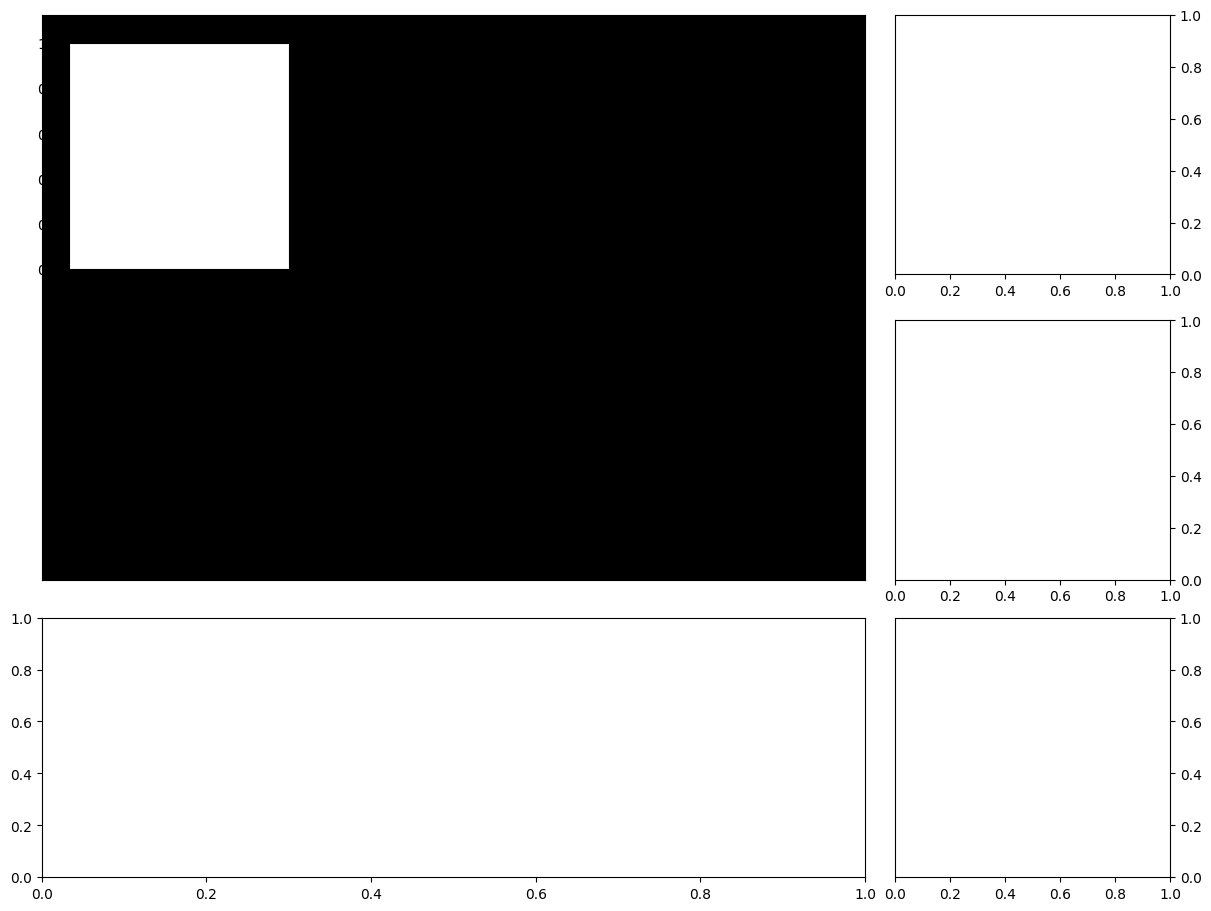

In [39]:
# fig = plt.figure(figsize=(12,9), layout="constrained")
# gs = gridspec.GridSpec(3, 4, figure=fig)

# ax0 = fig.add_subplot(gs[0:2, 0:3])
# ax0.set_facecolor("k")
# ax0.set_xticks([]); ax0.set_yticks([])

# ax00 = ax0.inset_axes([0.05*2/3, 0.55, 0.4*2/3, 0.4])

# sax1 = fig.add_subplot(gs[0,3]); sax1.yaxis.tick_right()
# sax2 = fig.add_subplot(gs[1,3]); sax2.yaxis.tick_right()
# sax3 = fig.add_subplot(gs[2,3]); sax3.yaxis.tick_right()
# lax = fig.add_subplot(gs[2,0:3])

In [18]:
mode1 = 'nh'
database1 = f"/home/jeon/MissingSat/database/{mode1}"
iout1 = 1026
repo1, rurmode1, dp1 = mode2repo(mode1)
snap1 = uri.RamsesSnapshot(repo1, iout1, mode=rurmode1)
snap1s = uri.TimeSeries(snap1)
snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']; nout=nout1[nout1 <= iout1]
gals1 = uhmi.HaloMaker.load(snap1, galaxy=True, double_precision=dp1)
hals1 = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp1)

LG1 = pklload(f"{database1}/LocalGroup.pickle")
allsats1 = None; allsubs1 = None; states1 = None
keys1 = list(LG1.keys())
for key in keys1:
    sats = LG1[key]['sats']; subs = LG1[key]['subs']; real = LG1[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True; subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'; state[~ind] = 'pair'
    
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsats1 = sats if allsats1 is None else np.hstack((allsats1, sats))
    allsubs1 = subs if allsubs1 is None else np.hstack((allsubs1, subs))
    states1 = state if states1 is None else np.hstack((states1, state))
argsort = np.argsort(allsubs1['id'])
allsubs1 = allsubs1[argsort]; states1 = states1[argsort]
dinks1 = allsubs1[states1 == 'dink']
pairs1 = allsubs1[states1 == 'pair']
upairs1 = allsubs1[states1 == 'upair']

print(len(allsubs1), np.unique(states1, return_counts=True))  

1336 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1145,  130,   61]))


In [19]:
mode2 = 'nh2'
database2 = f"/home/jeon/MissingSat/database/{mode2}"
iout2 = 797
repo2, rurmode2, dp2 = mode2repo(mode2)
snap2 = uri.RamsesSnapshot(repo2, iout2, mode=rurmode2)
snap2s = uri.TimeSeries(snap2)
snap2s.read_iout_avail()
nout2 = snap2s.iout_avail['iout']; nout=nout2[nout2 <= iout2]
gals2 = uhmi.HaloMaker.load(snap2, galaxy=True, double_precision=dp2)
hals2 = uhmi.HaloMaker.load(snap2, galaxy=False, double_precision=dp2)

LG2 = pklload(f"{database2}/LocalGroup.pickle")
allsats2 = None; allsubs2 = None; states2 = None
keys2 = list(LG2.keys())
for key in keys2:
    sats = LG2[key]['sats']; subs = LG2[key]['subs']; real = LG2[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True; subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'; state[~ind] = 'pair'
    
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsats2 = sats if allsats2 is None else np.hstack((allsats2, sats))
    allsubs2 = subs if allsubs2 is None else np.hstack((allsubs2, subs))
    states2 = state if states2 is None else np.hstack((states2, state))
argsort = np.argsort(allsubs2['id'])
allsubs2 = allsubs2[argsort]; states2 = states2[argsort]
dinks2 = allsubs2[states2 == 'dink']
pairs2 = allsubs2[states2 == 'pair']
upairs2 = allsubs2[states2 == 'upair']

print(len(allsubs2), np.unique(states2, return_counts=True))

1242 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1120,   79,   43]))


In [20]:
m1d, m2d = np.nanpercentile(np.hstack((dinks1['mvir'],dinks2['mvir'])), q=[2.5,97.5])
m1p, m2p = np.nanpercentile(np.hstack((pairs1['mvir'],pairs2['mvir'])), q=[2.5,97.5])
m1 = np.max([m1d,m1p]); m2 = np.min([m2d,m2p])
print(np.log10(m1), np.log10(m2))
rtree1 = pklload(f"{database1}/reduced_tree.pickle")
rtree2 = pklload(f"{database2}/reduced_tree.pickle")

8.43039019615325 9.33179360051326


Let's find these cases:  
- A) No star forever
- B) Initially no, but SF via merger(or other events)
- C) Initially no, but ex-situ star came in
- D) Initial SF

In [21]:
def draw_panel(iout, branch, zoom=1.5, dpi=240):
    global snap1s
    nh = snap1s.get_snap(iout)

    fig, axes = plt.subplots(2,3, dpi=100, figsize=(12,8))
    plt.subplots_adjust(hspace=0, wspace=0)
    for ax in axes.flatten(): ax.set_facecolor('k')
    vmaxs=np.zeros(4)


    target = branch[branch['timestep'] == iout][0]
    nh.set_box_halo(target, zoom*6)
    extent = nh.box[:2].flatten()
    xbins = np.linspace(extent[0], extent[1], dpi); ybins = np.linspace(extent[2], extent[3], dpi)
    part = nh.get_part(target_fields=['x','y','z','id','epoch','m'])

    indm = part['dm']
    indm = cut_sphere(indm, target['x'], target['y'], target['z'], target['rvir'])
    # DM Map
    hist, xe, ye = np.histogram2d(part['dm']['x'], part['dm']['y'], bins=[xbins, ybins], weights=part['dm']['m'])
    dA = (xe[1]-xe[0])*(ye[1]-ye[0])
    hist /= dA
    vmaxs[1] = np.log10(np.max(hist))
    axes[0,1].imshow(np.log10(hist.T), origin='lower', extent=extent, cmap=cmr.tree, vmax=vmaxs[1], vmin=vmaxs[1]-3)
    cir = circle(target, rname='rvir')
    axes[0,1].add_patch(cir)
    if(len(indm)>0): axes[0,1].text(target['x'], target['y']+target['rvir'], fr"$\mathbf{{10^{{{np.log10(np.sum(indm['m','Msol'])):.2f}}}}}$", color='lime', ha='center', va='bottom', fontsize=12)
    else: axes[0,1].text(target['x'], target['y']+target['rvir'], f"0", color='lime', ha='center', va='bottom', fontsize=12)
    if(len(part['dm'])>0): axes[0,1].text(0.03, 0.97, fr"$\mathbf{{10^{{{np.log10(np.sum(part['dm']['m','Msol'])):.2f}}}}}$", color='lime', ha='left', va='top', fontsize=12, transform=axes[0,1].transAxes)
    else: axes[0,1].text(0.03, 0.97, fr"0", color='lime', ha='left', va='top', fontsize=12, transform=axes[0,0].transAxes)
    axes[0,1].set_xticks([]); axes[0,1].set_yticks([])
    axes[0,1].set_title("Dark Matter", fontsize=15)
    axes[0,1].text(0.95, 0.95, f"z={1/nh.aexp-1:.3f}", color='w', ha='right', va='top', fontsize=14, transform=axes[0,1].transAxes)
    add_scalebar(axes[0,1], nh.unit_l, color='w', fontsize=12)

    nh.set_box_halo(target, zoom)
    extent = nh.box[:2].flatten()
    xbins = np.linspace(extent[0], extent[1], dpi)
    ybins = np.linspace(extent[2], extent[3], dpi)
    part = nh.get_part(target_fields=['x','y','z','id','epoch','m'])
    cell = nh.get_cell(target_fields=['x','y','z','rho','P','metal'])
    cold = cell[cell['T','K'] < 1e4]
    incell = cut_sphere(cell, target['x'], target['y'], target['z'], target['rvir'])
    incold = cut_sphere(cold, target['x'], target['y'], target['z'], target['rvir'])
    instar = part['star']
    instar = cut_sphere(instar, target['x'], target['y'], target['z'], target['rvir'])
    metalmap = painter.gasmap(cell, mode='metal', shape=dpi)
    metalmap = gaussian_filter(metalmap, int(dpi/70))
    metalmap = np.log10(metalmap/0.0142)

    # Star Map
    if(len(part['star'])<100)and(len(part['star'])>0):
        axes[0,0].scatter(part['star']['x'], part['star']['y'], s=200/len(part['star']), ec='none', fc='orange',marker="*")
        axes[0,0].set_xlim(*nh.box[0]); axes[0,0].set_ylim(*nh.box[1])
    else:
        hist, xe, ye = np.histogram2d(part['star']['x'], part['star']['y'], bins=[xbins, ybins], weights=part['star']['m'])
        dA = (xe[1]-xe[0])*(ye[1]-ye[0])
        hist /= dA
        vmaxs[0] = np.log10(np.max(hist))
        axes[0,0].imshow(np.log10(hist.T), origin='lower', extent=extent, cmap=cmr.sunburst, vmax=vmaxs[0], vmin=vmaxs[0]-3)
    cir = circle(target, rname='rvir')
    axes[0,0].add_patch(cir)
    if(len(instar)>0): axes[0,0].text(target['x'], target['y']+target['rvir'], fr"$\mathbf{{10^{{{np.log10(np.sum(instar['m','Msol'])):.2f}}}}}$", color='orange', ha='center', va='bottom', fontsize=12)
    else: axes[0,0].text(target['x'], target['y']+target['rvir'], f"0", color='orange', ha='center', va='bottom', fontsize=12)
    if(len(part['star'])>0): axes[0,0].text(0.03, 0.97, fr"$\mathbf{{10^{{{np.log10(np.sum(part['star']['m','Msol'])):.2f}}}}}$", color='orange', ha='left', va='top', fontsize=12, transform=axes[0,0].transAxes)
    else: axes[0,0].text(0.03, 0.97, fr"0", color='orange', ha='left', va='top', fontsize=12, transform=axes[0,0].transAxes)
    axes[0,0].set_xticks([]); axes[0,0].set_yticks([])
    axes[0,0].set_title("Star", fontsize=15)


    # Gas Map
    gasmap = painter.gasmap(cell, shape=dpi)
    vmaxs[2] = np.log10(np.max(gasmap))
    axes[1,0].imshow(np.log10(gasmap), origin='lower', extent=extent, cmap=cmr.neutral, vmax=vmaxs[2], vmin=vmaxs[2]-3)
    con_cmap = cmr.redshift
    con = axes[1,0].contour(metalmap,origin='lower', extent=extent, levels=np.linspace(-3, 0, 40), cmap=con_cmap, linewidths=0.2, linestyles='-')
    cir = circle(target, rname='rvir')
    axes[1,0].add_patch(cir)
    if(len(incell)>0): axes[1,0].text(target['x'], target['y']+target['rvir'], fr"$\mathbf{{10^{{{np.log10(np.sum(incell['m','Msol'])):.2f}}}}}$", color='whitesmoke', ha='center', va='bottom', fontsize=12)
    else: axes[1,0].text(target['x'], target['y']+target['rvir'], f"0", color='whitesmoke', ha='center', va='bottom', fontsize=12)
    if(len(cell)>0): axes[1,0].text(0.03, 0.97, fr"$\mathbf{{10^{{{np.log10(np.sum(cell['m','Msol'])):.2f}}}}}$", color='whitesmoke', ha='left', va='top', fontsize=12, transform=axes[1,0].transAxes)
    else: axes[1,0].text(0.03, 0.97, fr"0", color='whitesmoke', ha='left', va='top', fontsize=12, transform=axes[0,0].transAxes)
    axes[1,0].set_xticks([]); axes[1,0].set_yticks([])
    axes[1,0].set_xlabel("Gas + Metal", fontsize=15)
    axes[1,0].text(0.95, 0.05, fr"$f_b={(np.sum(incell['m'])+np.sum(instar['m']))/(np.sum(instar['m']) + np.sum(indm['m']) + np.sum(incell['m']))*100:.1f}$%", color='w', ha='right', va='bottom', fontsize=13, transform=axes[1,0].transAxes)
    cax = axes[1,0].inset_axes([0.05, 0.06, 0.3, 0.02])
    norm = Normalize(vmin=-3,vmax=0)
    sm = plt.cm.ScalarMappable(cmap=con_cmap, norm=norm)
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal', ticks=[-3,-2,-1,0])
    cbar.set_label(r"$log(Z/Z_\odot)$", color='w', fontsize=8)
    cbar.outline.set_edgecolor('w')
    # cbar.ax.xaxis.set_tick_params(color='w', size=8)
    # cax.tick_params(color='w', labelcolor='w')
    cax.spines['bottom'].set_color('w')
    cax.spines['top'].set_color('w')
    cax.spines['right'].set_color('w')
    cax.spines['left'].set_color('w')
    cax.tick_params(axis='x', colors='w', labelsize=8)
    cax.tick_params(axis='y', colors='w')
    cax.xaxis.tick_top()
    cax.xaxis.label.set_color('w')





    # Cold Map
    if(len(cold)>0):
        coldmap = painter.gasmap(cold, shape=dpi)
        vmaxs[3] = np.log10(np.max(coldmap))
        axes[1,1].imshow(np.log10(coldmap), origin='lower', extent=extent, cmap=cmr.arctic, vmax=vmaxs[3], vmin=vmaxs[3]-3)
    else:
        axes[1,1].set_xlim(*nh.box[0]); axes[1,1].set_ylim(*nh.box[1])
    cir = circle(target, rname='rvir')
    axes[1,1].add_patch(cir)
    if(len(incold)>0): axes[1,1].text(target['x'], target['y']+target['rvir'], fr"$\mathbf{{10^{{{np.log10(np.sum(incold['m','Msol'])):.2f}}}}}$", color='dodgerblue', ha='center', va='bottom', fontsize=12)
    else: axes[1,1].text(target['x'], target['y']+target['rvir'], f"0", color='dodgerblue', ha='center', va='bottom', fontsize=12)
    if(len(cold)>0): axes[1,1].text(0.03, 0.97, fr"$\mathbf{{10^{{{np.log10(np.sum(cold['m','Msol'])):.2f}}}}}$", color='dodgerblue', ha='left', va='top', fontsize=12, transform=axes[1,1].transAxes)
    else: axes[1,1].text(0.03, 0.97, fr"0", color='dodgerblue', ha='left', va='top', fontsize=12, transform=axes[0,0].transAxes)
    axes[1,1].set_xticks([]); axes[1,1].set_yticks([])
    axes[1,1].set_xlabel("Cold Gas", fontsize=15)

    # Phase Diagram
    ax = axes[0,2]
    ax.grid(True, zorder=0); ax.set_axisbelow(True); ax.set_facecolor('w')
    ax.scatter(cell['rho','H/cc'], cell['T','K'], s=0.5, fc='grey', ec='none', zorder=1)
    ax.scatter(cold['rho','H/cc'], cold['T','K'], s=1.0, fc='lightskyblue', ec='none', zorder=1)
    ax.scatter(incell['rho','H/cc'], incell['T','K'], s=1, fc='k', ec='none', zorder=1)
    ax.scatter(incold['rho','H/cc'], incold['T','K'], s=1.5, fc='dodgerblue', ec='none', zorder=1)
    # xtick
    ax.set_xscale('log'); ax.set_xlim(2e-6,1e3)
    ax.xaxis.tick_top()#; ax.tick_params(axis="x",direction="in", pad=-15)
    ax.set_xlabel(r'$\rho$ [H/cc]', fontsize=12); ax.xaxis.set_label_coords(0.5,1.15)
    #ytick
    ax.set_yscale('log'); ax.set_ylim(5e1,9e6)
    ax.yaxis.tick_right(); ax.tick_params(axis="y",direction="in", pad=-22)
    ax.set_ylabel('T [K]', fontsize=12); ax.yaxis.set_label_position("right")

    # Metallicity Histogram
    ax = axes[1,2]
    ax.set_facecolor('w')
    ax.hist(np.log10(cell['metal']/0.0142), bins=np.linspace(-3,0,20), histtype='step', color='grey')
    ax.hist(np.log10(cold['metal']/0.0142), bins=np.linspace(-3,0,20), histtype='step', color='lightskyblue')
    ax.hist(np.log10(incell['metal']/0.0142), bins=np.linspace(-3,0,20), histtype='stepfilled', color='k')
    ax.hist(np.log10(incold['metal']/0.0142), bins=np.linspace(-3,0,20), histtype='stepfilled', color='dodgerblue')
    # xtick
    # ax.tick_params(axis="x",direction="in", pad=-15)
    ax.set_xlabel(r'$log(Z/Z_\odot)$', fontsize=12)#; ax.xaxis.set_label_coords(0.5,1.1)
    #ytick
    ax.set_yscale('log'); ax.set_ylim(7,)
    ax.yaxis.tick_right(); ax.tick_params(axis="y",direction="in", pad=-22)
    ax.set_ylabel('$N_{cell}$', fontsize=12); ax.yaxis.set_label_position("right")

    nh.clear()
    plt.show(); plt.close()

  0%|          | 0/1336 [00:00<?, ?it/s]

43
5613 8.130581979667463
5936 8.426168365277922
20744 8.684488602034499
24319 8.701314060412125
25089 8.977625422872748
[935 934 933 932 931 930 929 928 927 926 925 924 923 922 921 920 919 918
 917 916 915 914 913 912 911 910 909 908 907 906 905 904 903 902 901 900
 899 897 896 895 894 893 892]
25089


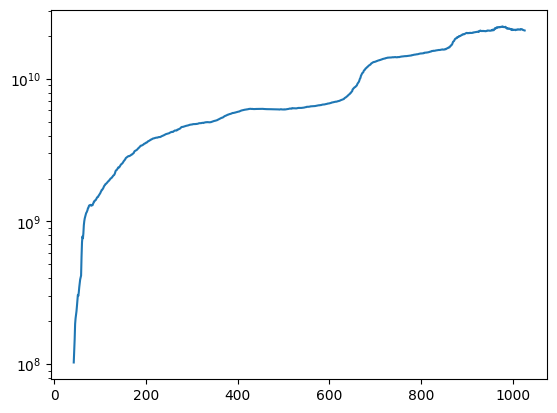

In [22]:
# Case A
ids = []
for target in tqdm(allsubs1):
    branch = rtree1[target['id']]
    if(np.min(branch['timestep']) > 60): continue
    if(np.sum(branch['mstar_vir']>0) > 100): continue
    ids.append(target['id'])
print(len(ids))
tid=0; mean_mass=0
for iid in ids:
    branch = rtree1[iid]; tmp = branch[branch['timestep'] < 100]
    tmp = np.mean(tmp['mdm_vir'])
    if(tmp > mean_mass):
        tid = iid; mean_mass = tmp
        print(iid, np.log10(mean_mass))

target = allsubs1[allsubs1['id'] == tid][0]
branch = rtree1[tid]
fig, ax = plt.subplots(dpi=100)
ax.plot(branch['timestep'], branch['mdm_vir'])
ax.set_yscale('log')
print(branch[branch['mstar_vir']>0]['timestep'])
print(target['id'])

In [245]:
snap1s.iout_avail['age']

array([ 0.05770493,  0.07068649,  0.0844265 ,  0.09897574,  0.11430082,
        0.13088087,  0.14384139,  0.15945525,  0.17542764,  0.18843741,
        0.2046418 ,  0.22085109,  0.23390814,  0.25049467,  0.26395555,
        0.28099757,  0.29299219,  0.30867634,  0.32409812,  0.33810332,
        0.35300607,  0.36804963,  0.3833188 ,  0.39800225,  0.41294642,
        0.42801747,  0.44307095,  0.45803492,  0.47296143,  0.48792115,
        0.5029112 ,  0.51796665,  0.53291469,  0.54793792,  0.56293732,
        0.57790805,  0.59292805,  0.60793212,  0.62288761,  0.63784847,
        0.65291203,  0.66786947,  0.68294068,  0.69788634,  0.71288546,
        0.72790041,  0.74290826,  0.75778625,  0.77288127,  0.78777591,
        0.80289044,  0.81787196,  0.83287605,  0.84785657,  0.86281343,
        0.87782334,  0.89283767,  0.90774098,  0.92270186,  0.9377516 ,
        0.95268488,  0.96777974,  0.98274285,  0.99777337,  1.01276825,
        1.02766863,  1.04275343,  1.05770966,  1.07267489,  1.08

In [105]:
import icl_draw
reload(icl_draw)
from icl_draw import add_scalebar

In [222]:
from functools import lru_cache


def out2gyr(outs, snaps):
    table = snaps.iout_avail
    gyrs = np.zeros(len(outs))

    iout_table = table['iout']
    gyr_table = table['age']
    @lru_cache(None)
    def gyrfromout(iout):
        arg = iout_table==iout
        return gyr_table[arg][0]
    
    for i, iout in enumerate(outs):
        gyrs[i] = gyrfromout(iout)#table[table['iout']==iout][0]['age']
    return gyrs

/tmp/ipykernel_19930/2802293023.py:39: RuntimeWarning: divide by zero encountered in log10
  ax_dm.imshow(np.log10(hist.T), origin='lower', extent=extent, cmap=cmr.tree, vmax=vmax, vmin=vmax-3)
/tmp/ipykernel_19930/2802293023.py:75: RuntimeWarning: divide by zero encountered in log10
  vmax = np.log10(np.max(hist))
/tmp/ipykernel_19930/2802293023.py:76: RuntimeWarning: divide by zero encountered in log10
  ax_star.imshow(np.log10(hist.T), origin='lower', extent=extent, cmap=cmr.sunburst, vmax=vmax, vmin=vmax-3)
/tmp/ipykernel_19930/2802293023.py:113: RuntimeWarning: divide by zero encountered in log10
  ax_cold.imshow(np.log10(coldmap), origin='lower', extent=extent, cmap=cmr.arctic, vmax=vmax, vmin=vmax-3)
/home/jeon/.conda/envs/jeonpy/lib/python3.10/site-packages/matplotlib/image.py:452: RuntimeWarning: invalid value encountered in double_scalars
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)


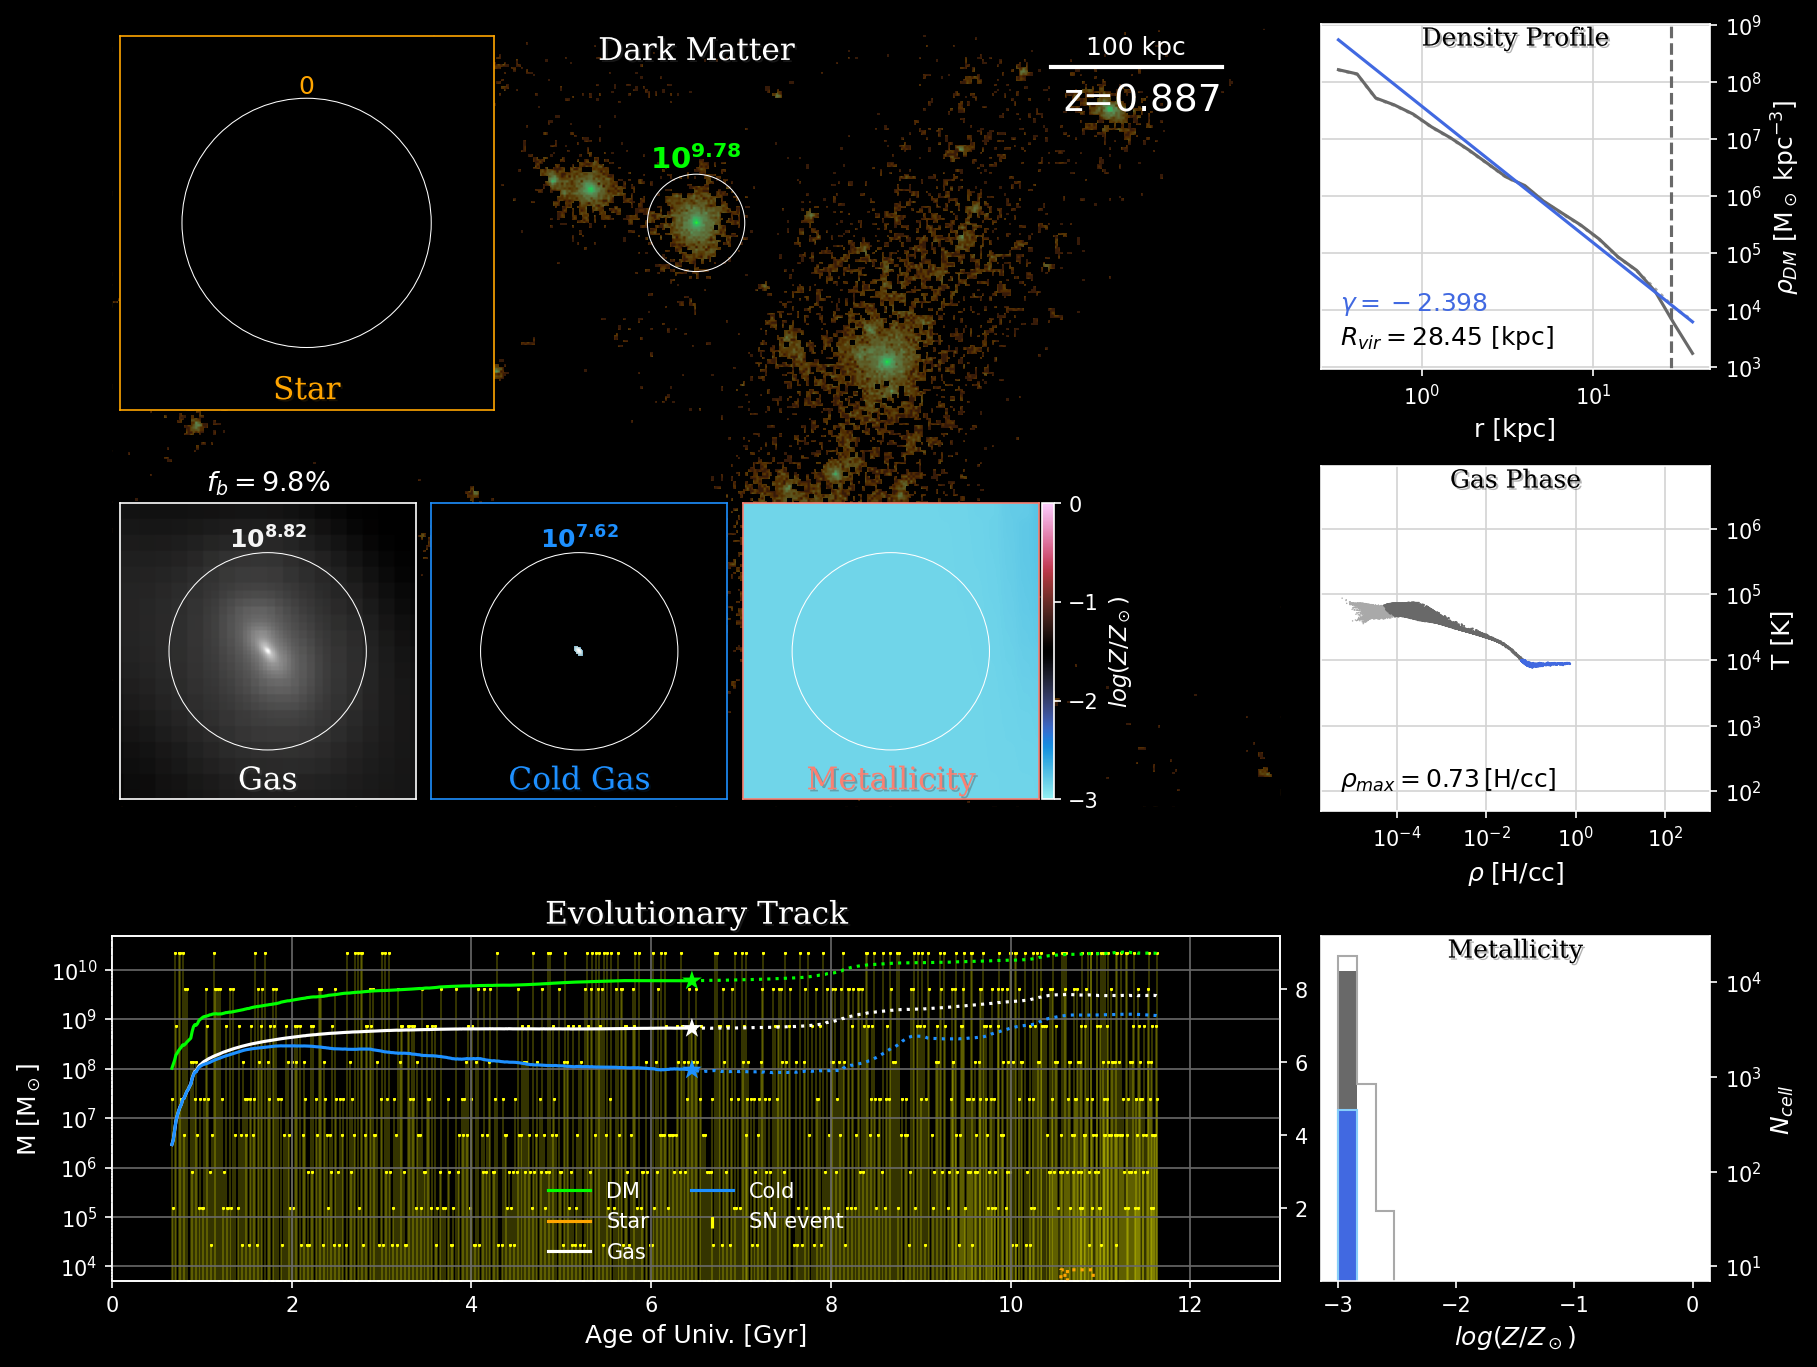

In [240]:
import matplotlib.patheffects as patheffects


if(os.path.exists(f"{database1}/photo/{target['id']:07d}/evolution.pickle")):
    evolution = pklload(f"{database1}/photo/{target['id']:07d}/evolution.pickle")
else:
    evolution = {}
    evolution['gamma'] = np.zeros(len(branch))
    evolution['rhomax'] = np.zeros(len(branch))
    evolution['metal'] = np.zeros(len(branch))
    evolution['nsn'] = np.zeros(len(branch))
###### Setting
iout=500
zoom=1.5
dpi=480
vmaxs=np.zeros(4)

fig = plt.figure(figsize=(12,9), layout="constrained", dpi=150, facecolor='k')
gs = gridspec.GridSpec(3, 4, figure=fig)



###### DM Map
# Data Process
nh = snap1s.get_snap(iout)
target = branch[branch['timestep'] == iout][0]
iarg = np.where(branch['timestep'] == iout)[0][0]
nh.set_box_halo(target, zoom*8)
extent = nh.box[:2].flatten()
xbins = np.linspace(extent[0], extent[1], dpi); ybins = np.linspace(extent[2], extent[3], dpi)
part = nh.get_part(target_fields=['x','y','z','id','epoch','m'])
indm = cut_sphere(part['dm'], target['x'], target['y'], target['z'], target['rvir'])
# Drawing
ax_dm = fig.add_subplot(gs[0:2, 0:3], facecolor='k', xticks=[], yticks=[])
hist, xe, ye = np.histogram2d(part['dm']['x'], part['dm']['y'], bins=[xbins, ybins], weights=part['dm']['m'])
dA = (xe[1]-xe[0])*(ye[1]-ye[0]); hist /= dA
vmax = np.log10(np.max(hist))
ycen = 0.5*(extent[2]+extent[3]); dy = extent[3]-extent[2]; y1 = extent[2]; y2 = ycen + dy/6
ax_dm.imshow(np.log10(hist.T), origin='lower', extent=extent, cmap=cmr.tree, vmax=vmax, vmin=vmax-3)
ax_dm.set_ylim(y1,y2)
# Info
cir = circle(target, rname='rvir'); ax_dm.add_patch(cir)
tmpstr = fr"$\mathbf{{10^{{{np.log10(np.sum(indm['m','Msol'])):.2f}}}}}$" if len(indm)>0 else "0"
ax_dm.text(target['x'], target['y']+target['rvir'], tmpstr, color='lime', ha='center', va='bottom', fontsize=14)
ax_dm.text(0.95, 0.93, f"z={1/nh.aexp-1:.3f}", color='w', ha='right', va='top', fontsize=18, transform=ax_dm.transAxes)
ax_dm.text(0.5,0.99, "Dark Matter", color='w', ha='center', va='top', fontsize=15, transform=ax_dm.transAxes, family='DejaVu Serif', path_effects=[patheffects.withSimplePatchShadow(offset=(1,-1))])
add_scalebar(ax_dm, nh.unit_l, color='w', fontsize=12, top=True)



###### Zoom-in
nh.set_box_halo(target, zoom)
extent = nh.box[:2].flatten()
xbins = np.linspace(extent[0], extent[1], dpi)
ybins = np.linspace(extent[2], extent[3], dpi)
part = nh.get_part(target_fields=['x','y','z','id','epoch','m'])
cell = nh.get_cell(target_fields=['x','y','z','rho','P','metal'])
buffer = 0.01
length = 0.5



###### Star Map
# Data Process
instar = cut_sphere(part['star'], target['x'], target['y'], target['z'], target['rvir'])
# Drawing
ax_star = ax_dm.inset_axes([buffer*2/3, 1-length+buffer, (length-buffer*2)*2/3, (length-buffer*2)], xticks=[], yticks=[], facecolor='k')
for spine in ax_star.spines.values(): spine.set_edgecolor('orange')
if(len(part['star'])<100)and(len(part['star'])>0):
    ax_star.scatter(part['star']['x'], part['star']['y'], s=200/len(part['star']), ec='none', fc='orange',marker="*")
    ax_star.set_xlim(*nh.box[0]); ax_star.set_ylim(*nh.box[1])
else:
    hist, xe, ye = np.histogram2d(part['star']['x'], part['star']['y'], bins=[xbins, ybins], weights=part['star']['m'])
    dA = (xe[1]-xe[0])*(ye[1]-ye[0]); hist /= dA
    vmax = np.log10(np.max(hist))
    ax_star.imshow(np.log10(hist.T), origin='lower', extent=extent, cmap=cmr.sunburst, vmax=vmax, vmin=vmax-3)
# Info
cir = circle(target, rname='rvir'); ax_star.add_patch(cir)
tmpstr = fr"$\mathbf{{10^{{{np.log10(np.sum(instar['m','Msol'])):.2f}}}}}$" if len(instar)>0 else "0"
ax_star.text(target['x'], target['y']+target['rvir'], tmpstr, color='orange', ha='center', va='bottom', fontsize=12)
ax_star.text(0.5,0.01, "Star", color='orange', ha='center', va='bottom', fontsize=15, transform=ax_star.transAxes, family='DejaVu Serif', path_effects=[patheffects.withSimplePatchShadow(offset=(1,-1))])


length = 0.4
###### Gas Map
# Data Process
incell = cut_sphere(cell, target['x'], target['y'], target['z'], target['rvir'])
# Drawing
ax_gas = ax_dm.inset_axes([buffer*2/3, buffer, (length-buffer*2)*2/3, (length-buffer*2)], xticks=[], yticks=[], facecolor='k')
for spine in ax_gas.spines.values(): spine.set_edgecolor('white')
gasmap = painter.gasmap(cell, shape=dpi)
vmax = np.log10(np.max(gasmap))
ax_gas.imshow(np.log10(gasmap), origin='lower', extent=extent, cmap=cmr.neutral, vmax=vmax, vmin=vmax-3)
# Info
cir = circle(target, rname='rvir'); ax_gas.add_patch(cir)
tmpstr = fr"$\mathbf{{10^{{{np.log10(np.sum(incell['m','Msol'])):.2f}}}}}$" if len(incell)>0 else "0"
ax_gas.text(target['x'], target['y']+target['rvir'], tmpstr, color='whitesmoke', ha='center', va='bottom', fontsize=12)
ax_gas.set_title(fr"$f_b={(np.sum(incell['m'])+np.sum(instar['m']))/(np.sum(instar['m']) + np.sum(indm['m']) + np.sum(incell['m']))*100:.1f}$%", color='w',fontsize=13)
ax_gas.text(0.5,0.01, "Gas", color='w', ha='center', va='bottom', fontsize=15, transform=ax_gas.transAxes, family='DejaVu Serif', path_effects=[patheffects.withSimplePatchShadow(offset=(1,-1))])



###### Cold Map
# Data Process
cold = cell[cell['T','K'] < 1e4]
incold = cut_sphere(cold, target['x'], target['y'], target['z'], target['rvir'])
# Drawing
ax_cold = ax_dm.inset_axes([(length+buffer)*2/3, buffer, (length-buffer*2)*2/3, (length-buffer*2)], xticks=[], yticks=[], facecolor='k')
for spine in ax_cold.spines.values(): spine.set_edgecolor('dodgerblue')
if(len(cold)>0):
    coldmap = painter.gasmap(cold, shape=dpi)
    vmax = np.log10(np.max(coldmap))
    ax_cold.imshow(np.log10(coldmap), origin='lower', extent=extent, cmap=cmr.arctic, vmax=vmax, vmin=vmax-3)
else:
    ax_cold.set_xlim(*nh.box[0]); ax_cold.set_ylim(*nh.box[1])
# Info
cir = circle(target, rname='rvir')
ax_cold.add_patch(cir)
tmpstr = fr"$\mathbf{{10^{{{np.log10(np.sum(incold['m','Msol'])):.2f}}}}}$" if len(incold)>0 else "0"
ax_cold.text(target['x'], target['y']+target['rvir'], tmpstr, color='dodgerblue', ha='center', va='bottom', fontsize=12)
ax_cold.text(0.5,0.01, "Cold Gas", color='dodgerblue', ha='center', va='bottom', fontsize=15, transform=ax_cold.transAxes, family='DejaVu Serif', path_effects=[patheffects.withSimplePatchShadow(offset=(1,-1))])



###### Metal Map
# Data Process
metalmap = painter.gasmap(cell, mode='metal', shape=dpi)
metalmap = gaussian_filter(metalmap, int(dpi/70))
metalmap = np.log10(metalmap/0.0142)
# Drawing
ax_metal = ax_dm.inset_axes([(2*length+buffer)*2/3, buffer, (length-buffer*2)*2/3, (length-buffer*2)], xticks=[], yticks=[], facecolor='k')
for spine in ax_metal.spines.values(): spine.set_edgecolor('salmon')
metal_cmap = cmr.redshift
ax_metal.imshow(metalmap, origin='lower', extent=extent, cmap=metal_cmap, vmax=0, vmin=-3)
# Info
cir = circle(target, rname='rvir'); ax_metal.add_patch(cir)
ax_metal.text(0.5,0.01, "Metallicity", color='salmon', ha='center', va='bottom', fontsize=15, transform=ax_metal.transAxes, family='DejaVu Serif', path_effects=[patheffects.withSimplePatchShadow(offset=(1,-1))])
# Colorbar
cax = ax_metal.inset_axes([1.01, 0.00, 0.04, 1.0])
norm = Normalize(vmin=-3,vmax=0); sm = plt.cm.ScalarMappable(cmap=metal_cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cax, orientation='vertical', ticks=[-3,-2,-1,0])
cbar.set_label(r"$log(Z/Z_\odot)$", color='w', fontsize=11)
cbar.outline.set_edgecolor('w')
for spine in cax.spines.values(): spine.set_edgecolor('w')
cax.tick_params(axis='x', colors='w', labelsize=8); cax.tick_params(axis='y', colors='w')



###### DM density profile
def single(logr, const, gamma): return gamma * logr + const

r1 = 34*nh.unit['pc']; r2 = zoom*target['rvir']
r1 = max(r1, np.min(cell['dx']))
bins = np.logspace(np.log10(r1), np.log10(r2), 20+1)
xs = 0.5*(bins[:-1]+bins[1:])/nh.unit['kpc'] # kpc
sax1 = fig.add_subplot(gs[0,3]); sax1.yaxis.tick_right()
sax1.grid(True, zorder=0, color='lightgray'); sax1.set_axisbelow(True)
# All Particles
ys = np.zeros(len(xs))
dist = distance(part['dm'], target)
for i in range(len(xs)):
    ind = (dist > bins[i]) & (dist < bins[i+1])
    vol = (4/3*np.pi*(bins[i+1]**3-bins[i]**3)) # code**3
    vol /= nh.unit['kpc']**3
    ys[i] = np.sum(part['dm'][ind]['m','Msol']) / vol # Msol/kpc3
sax1.plot(xs, ys, color='darkgray', lw=1.5, ls=':')
# Member Particles
ys = np.zeros(len(xs))
ws = np.zeros(len(xs))
member = uhmi.HaloMaker.read_member_part(nh, target['id'], galaxy=False, target_fields=['id','x','y','z','m'])
dist = distance(member, target)
for i in range(len(xs)):
    ind = (dist > bins[i]) & (dist < bins[i+1])
    vol = (4/3*np.pi*(bins[i+1]**3-bins[i]**3)) # code**3
    vol /= nh.unit['kpc']**3
    ys[i] = np.sum(member[ind]['m','Msol']) / vol # Msol/kpc3
    ws[i] = 1 / np.sqrt(np.sum(member[ind]['m']))
ws /= np.sum(ws)
sax1.plot(xs, ys, color='dimgrey', lw=1.5, ls='-')
from scipy.optimize import curve_fit
try: popt, pcov = curve_fit(single, np.log10(xs), np.log10(ys), p0=[1, -2], bounds=([-np.inf, -3.5], [np.inf, 0.5]), sigma=ws, maxfev=5000, method='trf')
except: popt = np.zeros(2)*np.nan; pcov = np.zeros(2)*np.nan
sax1.plot(xs, 10**single(np.log10(xs), *popt), color='royalblue', lw=1.5, ls='-')
sax1.axvline(target['rvir']/nh.unit['kpc'], color='dimgrey', linestyle='--', lw=1.5)
sax1.text(0.05, 0.15, fr"$\gamma={popt[1]:.3f}$", ha='left', va='bottom', fontsize=12, transform=sax1.transAxes, color='royalblue')
sax1.text(0.05, 0.05, fr"$R_{{vir}}={target['rvir']/nh.unit['kpc']:.2f}$ [kpc]", ha='left', va='bottom', fontsize=12, transform=sax1.transAxes)
sax1.text(0.5, 0.99, "Density Profile", ha='center', va='top', fontsize=12, transform=sax1.transAxes, family='DejaVu Serif', path_effects=[patheffects.withSimplePatchShadow(offset=(1,-1))])
sax1.set_xscale('log'); sax1.set_xlabel('r [kpc]', fontsize=12)
sax1.set_yscale('log'); sax1.set_ylabel(r'$\rho_{DM}$ [M$_\odot$ kpc$^{-3}$]', fontsize=12); sax1.yaxis.set_label_position("right")
ax_change_color(sax1, 'w')
evolution['gamma'][iarg] = popt[1]



###### Phase Diagram
sax2 = fig.add_subplot(gs[1,3], facecolor='w'); sax2.yaxis.tick_right()
sax2.grid(True, zorder=0, color='lightgray'); sax2.set_axisbelow(True)
sax2.scatter(cell['rho','H/cc'], cell['T','K'], s=0.5, fc='darkgray', ec='none', zorder=1)
sax2.scatter(cold['rho','H/cc'], cold['T','K'], s=1.0, fc='lightskyblue', ec='none', zorder=1)
sax2.scatter(incell['rho','H/cc'], incell['T','K'], s=1, fc='dimgrey', ec='none', zorder=1)
sax2.scatter(incold['rho','H/cc'], incold['T','K'], s=1.5, fc='royalblue', ec='none', zorder=1)
sax2.set_xscale('log'); sax2.set_xlim(2e-6,1e3); sax2.set_xlabel(r'$\rho$ [H/cc]', fontsize=12)
sax2.set_yscale('log'); sax2.set_ylim(5e1,9e6); sax2.set_ylabel('T [K]', fontsize=12); sax2.yaxis.set_label_position("right")
sax2.text(0.05, 0.05, fr"$\rho_{{max}}={np.max(incell['rho','H/cc']):.2f}\,$[H/cc]", ha='left', va='bottom', fontsize=12, transform=sax2.transAxes)
sax2.text(0.5, 0.99, "Gas Phase", ha='center', va='top', fontsize=12, transform=sax2.transAxes, family='DejaVu Serif', path_effects=[patheffects.withSimplePatchShadow(offset=(1,-1))])
ax_change_color(sax2, 'w')
evolution['rhomax'][iarg] = np.max(incell['rho','H/cc'])



###### Metallicity Histogram
sax3 = fig.add_subplot(gs[2,3]); sax3.yaxis.tick_right()
sax3.hist(np.log10(cell['metal']/0.0142), bins=np.linspace(-3,0,20), histtype='step', color='darkgray')
sax3.hist(np.log10(cold['metal']/0.0142), bins=np.linspace(-3,0,20), histtype='step', color='lightskyblue')
sax3.hist(np.log10(incell['metal']/0.0142), bins=np.linspace(-3,0,20), histtype='stepfilled', color='dimgrey')
sax3.hist(np.log10(incold['metal']/0.0142), bins=np.linspace(-3,0,20), histtype='stepfilled', color='royalblue')
sax3.set_xlabel(r'$log(Z/Z_\odot)$', fontsize=12)
sax3.set_yscale('log'); sax3.set_ylim(7,); sax3.set_ylabel('$N_{cell}$', fontsize=12); sax3.yaxis.set_label_position("right")
sax3.text(0.5, 0.99, "Metallicity", ha='center', va='top', fontsize=12, transform=sax3.transAxes, family='DejaVu Serif', path_effects=[patheffects.withSimplePatchShadow(offset=(1,-1))])
ax_change_color(sax3, 'w')
evolution['metal'][iarg] = np.mean(incell['metal']/0.0142)



###### Evolutionary Track
lax = fig.add_subplot(gs[2,0:3], facecolor='k')
lax.grid(True, zorder=0, color='dimgrey'); lax.set_axisbelow(True)
# Mass Evolution
tmp = branch[branch['timestep'] < iout]
l1=lax.plot(out2gyr(tmp['timestep'], snap1s), tmp['mdm_vir'], color='lime', label='DM')
l2=lax.plot(out2gyr(tmp['timestep'], snap1s), tmp['mstar_vir'], color='orange', label='Star')
l3=lax.plot(out2gyr(tmp['timestep'], snap1s), tmp['mcell_vir'], color='w', label='Gas')
l4=lax.plot(out2gyr(tmp['timestep'], snap1s), tmp['mcold_vir'], color='dodgerblue', label='Cold')
tmp = branch[branch['timestep'] > iout]
lax.plot(out2gyr(tmp['timestep'], snap1s), tmp['mdm_vir'], color='lime', ls=':')
lax.plot(out2gyr(tmp['timestep'], snap1s), tmp['mstar_vir'], color='orange', ls=':')
lax.plot(out2gyr(tmp['timestep'], snap1s), tmp['mcell_vir'], color='w', ls=':')
lax.plot(out2gyr(tmp['timestep'], snap1s), tmp['mcold_vir'], color='dodgerblue', ls=':')
tmp = branch[branch['timestep'] == iout]
lax.scatter(out2gyr(tmp['timestep'], snap1s), tmp['mdm_vir'], s=100,ec='none',fc='lime', marker='*')
lax.scatter(out2gyr(tmp['timestep'], snap1s), tmp['mstar_vir'], s=100,ec='none',fc='orange', marker='*')
lax.scatter(out2gyr(tmp['timestep'], snap1s), tmp['mcell_vir'], s=100,ec='none',fc='w', marker='*')
lax.scatter(out2gyr(tmp['timestep'], snap1s), tmp['mcold_vir'], s=100,ec='none',fc='dodgerblue', marker='*')

lax2 = lax.twinx(); lax2.set_zorder(-1); lax.patch.set_visible(False)
# SN event
nsn = np.random.randint(0,10, len(branch))
stemcontainer = lax2.stem(out2gyr(branch['timestep'], snap1s), nsn, linefmt='yellow', markerfmt='yellow', basefmt='none', label='SN event')
markerline, stemlines, baseline = stemcontainer
markerline.set_markersize(1)
markerline.set_marker('*')
stemlines.set_linewidth(0.2)
stemlines.set_zorder(-1)
stemlines.set_alpha(0.5)
lax2.set_ylim(0.001,)

lines = l1+l2+l3+l4+[stemcontainer]
labels = [l.get_label() for l in lines]
# lax2.legend(loc='lower left', frameon=False, labelcolor='w')

lax.legend(lines, labels, loc='lower center', frameon=False, labelcolor='w', ncol=2)
lax.set_xlabel("Age of Univ. [Gyr]", fontsize=12), lax.set_xlim(0,13)
lax.set_yscale('log'); lax.set_ylabel("M [M$_\odot$]", fontsize=12); lax.set_ylim(5e3,)
lax.set_title("Evolutionary Track", fontsize=15, color='w', family='DejaVu Serif', path_effects=[patheffects.withSimplePatchShadow(offset=(1,-1))])


# lax.text(0.5, 0.5, "Mass Evolution\nSN event", ha='center', va='center', fontsize=20, transform=lax.transAxes)
ax_change_color(lax, 'w')
ax_change_color(lax2, 'w')

In [241]:
nh.nstar

array([208886863], dtype=int32)

In [ ]:
s

In [236]:
st = lax2.stem(1/branch['aexp']-1, nsn, linefmt='yellow', markerfmt='yellow', basefmt='none', label='SN event')
st.get_label()

'SN event'

In [242]:
star = uri.Particle(nh.part_data, nh)['star']

In [243]:
np.min(star['id'])

-208860012

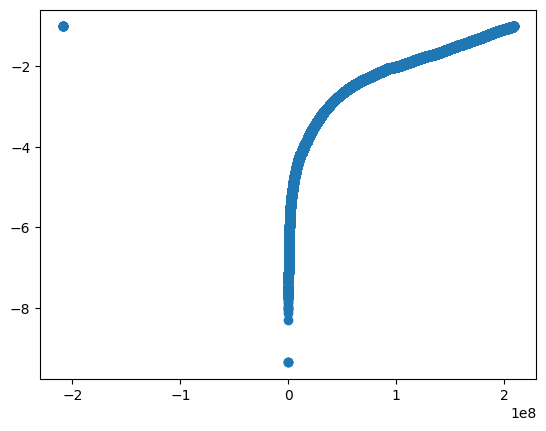

In [193]:
plt.scatter(star['id'], star['epoch'])

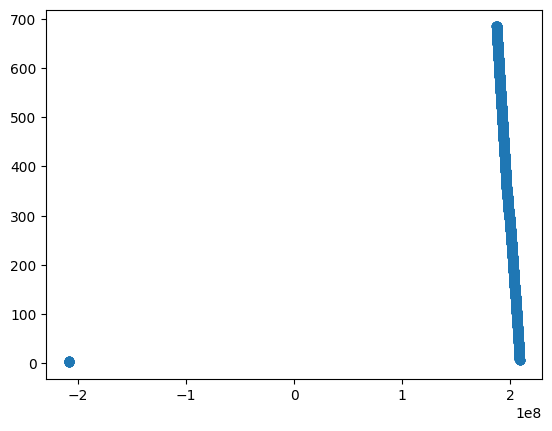

In [197]:
tmp = star[star['epoch']>-1.2]
plt.scatter(tmp['id'], tmp['age','Myr'])

In [202]:
neg = tmp[tmp['id']<0]
print(np.max(neg['age','Myr']))

4.408552775688968


In [203]:
pos = tmp[tmp['id']>0]
print(np.min(pos['age','Myr']))

5.098771074272258


In [186]:
part['star']

Particle({'table': array([],
      dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('epoch', '<f8'), ('id', '<i4'), ('cpu', '<i4')]), 'snap': <rur.uri.RamsesSnapshot object at 0x7fa87b675de0>, 'extra_fields': {'pos': <function custom_extra_fields.<locals>.<lambda> at 0x7fa85fe27d90>, 'vel': <function custom_extra_fields.<locals>.<lambda> at 0x7fa85fe26830>, 'age': <function custom_extra_fields.<locals>.<lambda> at 0x7fa85fe27d00>, 'aform': <function custom_extra_fields.<locals>.<lambda> at 0x7fa85fe27ac0>, 'zform': <function custom_extra_fields.<locals>.<lambda> at 0x7fa85fe279a0>, 'dx': <function custom_extra_fields.<locals>.<lambda> at 0x7fa85fe269e0>}, 'units': defaultdict(<function defnone at 0x7fa837427d90>, {}), 'ptype': 'star'})

In [149]:
10**single(np.log10(xs), *popt)

array([9.51548347e+09, 4.22918150e+09, 1.87967077e+09, 8.35424589e+08,
       3.71306642e+08, 1.65028208e+08, 7.33472183e+07, 3.25993629e+07,
       1.44888720e+07, 6.43961706e+06, 2.86210463e+06, 1.27206989e+06,
       5.65374786e+05, 2.51282301e+05, 1.11683076e+05, 4.96378349e+04,
       2.20616655e+04, 9.80536489e+03, 4.35802006e+03, 1.93693341e+03])

In [157]:
r1

115.63489906511276

/tmp/ipykernel_8594/619309200.py:24: RuntimeWarning: divide by zero encountered in log10
  axes[0,1].imshow(np.log10(hist.T), origin='lower', extent=extent, cmap=cmr.tree, vmax=vmaxs[1], vmin=vmaxs[1]-3)
/tmp/ipykernel_8594/619309200.py:59: RuntimeWarning: divide by zero encountered in log10
  vmaxs[0] = np.log10(np.max(hist))
/tmp/ipykernel_8594/619309200.py:60: RuntimeWarning: divide by zero encountered in log10
  axes[0,0].imshow(np.log10(hist.T), origin='lower', extent=extent, cmap=cmr.sunburst, vmax=vmaxs[0], vmin=vmaxs[0]-3)
/tmp/ipykernel_8594/619309200.py:111: RuntimeWarning: divide by zero encountered in log10
  axes[1,1].imshow(np.log10(coldmap), origin='lower', extent=extent, cmap=cmr.arctic, vmax=vmaxs[3], vmin=vmaxs[3]-3)


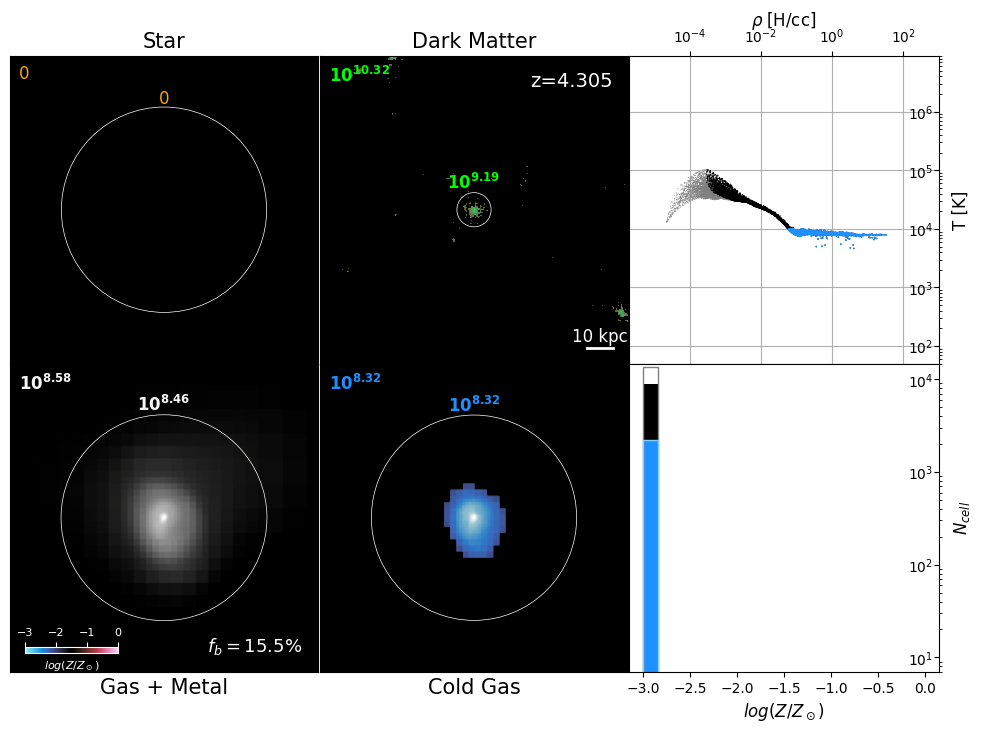

In [52]:
draw_panel(100, branch, dpi=360)

(1965, 24450, 1026, 3, 5461, 24178, 0, 24451, 0.85361391, 2.57387478e+09, 0.50045871, 0.54342636, 0.55196622, 87.00230158, -70.08623218, 184.28282584, 19676003.81847379, 2426171.11962637, -28669508.71809936, 0.00033727, 0.00522622, 0.00795719, 0.00606749, 41.56686977, -13.36438386, 28.20248592, 0.04049383, 25.68845571, 0.0002645, 2.56995914e+09, 12373.18318553, 18.56493734, 61.9997968, 0.0002645, 10441682.66101253, 8.94822367e-06, 5.86239567e-05, 0.00015149, 1.96725834e-05, 0.00011157, 0.00031037, 1.32344424e-05, 0.0001111, 0.00030299, 0, False, 3.91160485e+09, 5722507.5738459, 10638077.5730479, 1.8823833e+08, 7, 24.5062533, 2.72687298e+09, 0.00020211, 3.13108409e+09, 5714042.3259556, 1.02409728e+08, 10638077.5730479)
9.495694731847864


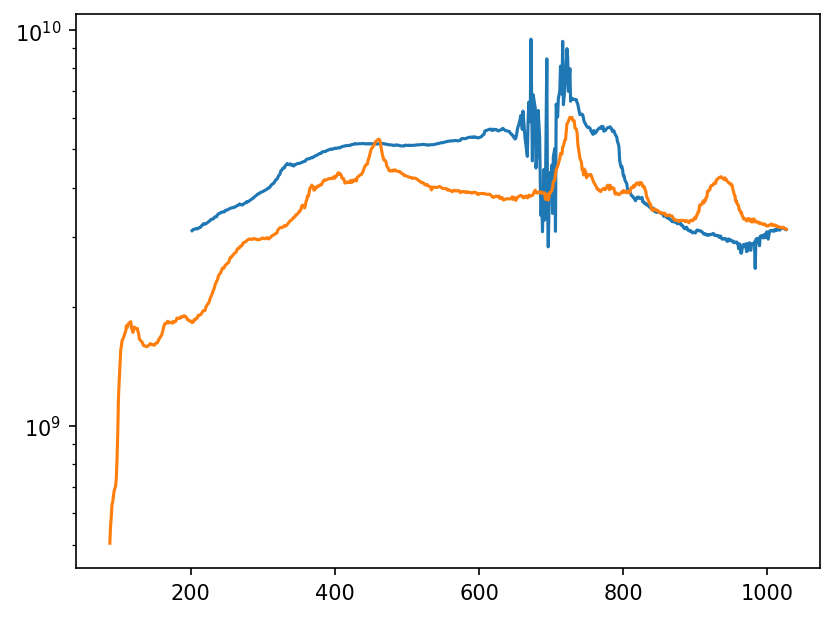

In [5]:
ptarget = np.random.choice(pairs1)
# ptarget = pairs1[pairs1['id'] == 28401][0]
print(ptarget)
print(np.log10(ptarget['mdm_vir']))
dtarget = dinks1[np.argmin(np.abs(dinks1['mdm_vir'] - ptarget['mdm_vir']))]

fig, ax = plt.subplots(dpi=150)

pbranch = rtree1[ptarget['id']]
ax.plot(pbranch['timestep'], pbranch['mdm_vir'])
dbranch = rtree1[dtarget['id']]
ax.plot(dbranch['timestep'], dbranch['mdm_vir'])
ax.set_yscale('log')

---

In [14]:
branch = pbranch
branch['timestep'][-60:]

array([100,  99,  98,  97,  96,  94,  93,  92,  91,  90,  89,  88,  87,
        86,  85,  84,  83,  82,  81,  80,  79,  77,  76,  75,  74,  73,
        72,  71,  70,  69,  67,  66,  65,  64,  63,  62,  61,  60,  59,
        57,  56,  55,  54,  53,  52,  51,  50,  49,  47,  46,  45,  44,
        43,  42,  41,  40,  39,  38,  36,  35], dtype=int32)

/tmp/ipykernel_7460/1059181990.py:26: RuntimeWarning: divide by zero encountered in log10
  axes[0,1].imshow(np.log10(hist.T), origin='lower', extent=extent, cmap=cmr.jungle, vmax=vmaxs[1], vmin=vmaxs[1]-3)
/tmp/ipykernel_7460/1059181990.py:113: RuntimeWarning: divide by zero encountered in log10
  axes[1,1].imshow(np.log10(coldmap), origin='lower', extent=extent, cmap=cmr.arctic, vmax=vmaxs[3], vmin=vmaxs[3]-3)


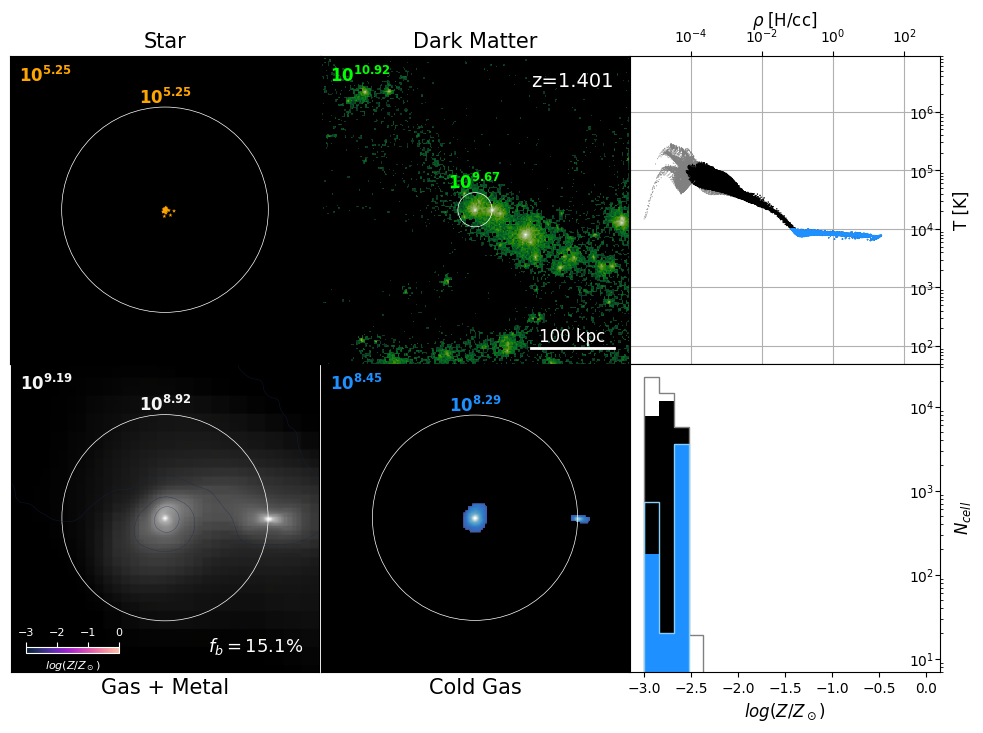

In [20]:
iout = 352
zoom = 1.5
dpi = 240
nh = snap1s.get_snap(iout)
fig, axes = plt.subplots(2,3, dpi=100, figsize=(12,8))
plt.subplots_adjust(hspace=0, wspace=0)
for ax in axes.flatten():
    ax.set_facecolor('k')
vmaxs=np.zeros(4)


target = branch[branch['timestep'] == iout][0]
nh.set_box_halo(target, zoom*6)
extent = nh.box[:2].flatten()
xbins = np.linspace(extent[0], extent[1], dpi)
ybins = np.linspace(extent[2], extent[3], dpi)
part = nh.get_part(target_fields=['x','y','z','id','epoch','m'])

indm = part['dm']
indm = cut_sphere(indm, target['x'], target['y'], target['z'], target['rvir'])
# DM Map
hist, xe, ye = np.histogram2d(part['dm']['x'], part['dm']['y'], bins=[xbins, ybins], weights=part['dm']['m'])
dA = (xe[1]-xe[0])*(ye[1]-ye[0])
hist /= dA
vmaxs[1] = np.log10(np.max(hist))
axes[0,1].imshow(np.log10(hist.T), origin='lower', extent=extent, cmap=cmr.jungle, vmax=vmaxs[1], vmin=vmaxs[1]-3)
cir = circle(target, rname='rvir')
axes[0,1].add_patch(cir)
if(len(indm)>0): axes[0,1].text(target['x'], target['y']+target['rvir'], fr"$\mathbf{{10^{{{np.log10(np.sum(indm['m','Msol'])):.2f}}}}}$", color='lime', ha='center', va='bottom', fontsize=12)
else: axes[0,1].text(target['x'], target['y']+target['rvir'], f"0", color='lime', ha='center', va='bottom', fontsize=12)
if(len(part['dm'])>0): axes[0,1].text(0.03, 0.97, fr"$\mathbf{{10^{{{np.log10(np.sum(part['dm']['m','Msol'])):.2f}}}}}$", color='lime', ha='left', va='top', fontsize=12, transform=axes[0,1].transAxes)
else: axes[0,1].text(0.03, 0.97, fr"0", color='lime', ha='left', va='top', fontsize=12, transform=axes[0,0].transAxes)
axes[0,1].set_xticks([]); axes[0,1].set_yticks([])
axes[0,1].set_title("Dark Matter", fontsize=15)
axes[0,1].text(0.95, 0.95, f"z={1/nh.aexp-1:.3f}", color='w', ha='right', va='top', fontsize=14, transform=axes[0,1].transAxes)
add_scalebar(axes[0,1], nh.unit_l, color='w', fontsize=12)

nh.set_box_halo(target, zoom)
extent = nh.box[:2].flatten()
xbins = np.linspace(extent[0], extent[1], dpi)
ybins = np.linspace(extent[2], extent[3], dpi)
part = nh.get_part(target_fields=['x','y','z','id','epoch','m'])
cell = nh.get_cell(target_fields=['x','y','z','rho','P','metal'])
cold = cell[cell['T','K'] < 1e4]
incell = cut_sphere(cell, target['x'], target['y'], target['z'], target['rvir'])
incold = cut_sphere(cold, target['x'], target['y'], target['z'], target['rvir'])
instar = part['star']
instar = cut_sphere(instar, target['x'], target['y'], target['z'], target['rvir'])
metalmap = painter.gasmap(cell, mode='metal', shape=dpi)
metalmap = gaussian_filter(metalmap, int(dpi/70))
metalmap = np.log10(metalmap/0.0142)

# Star Map
if(len(part['star'])<100)and(len(part['star'])>0):
    axes[0,0].scatter(part['star']['x'], part['star']['y'], s=200/len(part['star']), ec='none', fc='orange',marker="*")
    axes[0,0].set_xlim(*nh.box[0]); axes[0,0].set_ylim(*nh.box[1])
else:
    hist, xe, ye = np.histogram2d(part['star']['x'], part['star']['y'], bins=[xbins, ybins], weights=part['star']['m'])
    dA = (xe[1]-xe[0])*(ye[1]-ye[0])
    hist /= dA
    vmaxs[0] = np.log10(np.max(hist))
    axes[0,0].imshow(np.log10(hist.T), origin='lower', extent=extent, cmap=cmr.sunburst, vmax=vmaxs[0], vmin=vmaxs[0]-3)
cir = circle(target, rname='rvir')
axes[0,0].add_patch(cir)
if(len(instar)>0): axes[0,0].text(target['x'], target['y']+target['rvir'], fr"$\mathbf{{10^{{{np.log10(np.sum(instar['m','Msol'])):.2f}}}}}$", color='orange', ha='center', va='bottom', fontsize=12)
else: axes[0,0].text(target['x'], target['y']+target['rvir'], f"0", color='orange', ha='center', va='bottom', fontsize=12)
if(len(part['star'])>0): axes[0,0].text(0.03, 0.97, fr"$\mathbf{{10^{{{np.log10(np.sum(part['star']['m','Msol'])):.2f}}}}}$", color='orange', ha='left', va='top', fontsize=12, transform=axes[0,0].transAxes)
else: axes[0,0].text(0.03, 0.97, fr"0", color='orange', ha='left', va='top', fontsize=12, transform=axes[0,0].transAxes)
axes[0,0].set_xticks([]); axes[0,0].set_yticks([])
axes[0,0].set_title("Star", fontsize=15)


# Gas Map
gasmap = painter.gasmap(cell, shape=dpi)
vmaxs[2] = np.log10(np.max(gasmap))
axes[1,0].imshow(np.log10(gasmap), origin='lower', extent=extent, cmap=cmr.neutral, vmax=vmaxs[2], vmin=vmaxs[2]-3)
con_cmap = cmr.bubblegum
con = axes[1,0].contour(metalmap,origin='lower', extent=extent, levels=np.linspace(-3, 0, 40), cmap=con_cmap, linewidths=0.2, linestyles='-')
cir = circle(target, rname='rvir')
axes[1,0].add_patch(cir)
if(len(incell)>0): axes[1,0].text(target['x'], target['y']+target['rvir'], fr"$\mathbf{{10^{{{np.log10(np.sum(incell['m','Msol'])):.2f}}}}}$", color='whitesmoke', ha='center', va='bottom', fontsize=12)
else: axes[1,0].text(target['x'], target['y']+target['rvir'], f"0", color='whitesmoke', ha='center', va='bottom', fontsize=12)
if(len(cell)>0): axes[1,0].text(0.03, 0.97, fr"$\mathbf{{10^{{{np.log10(np.sum(cell['m','Msol'])):.2f}}}}}$", color='whitesmoke', ha='left', va='top', fontsize=12, transform=axes[1,0].transAxes)
else: axes[1,0].text(0.03, 0.97, fr"0", color='whitesmoke', ha='left', va='top', fontsize=12, transform=axes[0,0].transAxes)
axes[1,0].set_xticks([]); axes[1,0].set_yticks([])
axes[1,0].set_xlabel("Gas + Metal", fontsize=15)
axes[1,0].text(0.95, 0.05, fr"$f_b={(np.sum(incell['m'])+np.sum(instar['m']))/(np.sum(instar['m']) + np.sum(indm['m']) + np.sum(incell['m']))*100:.1f}$%", color='w', ha='right', va='bottom', fontsize=13, transform=axes[1,0].transAxes)
cax = axes[1,0].inset_axes([0.05, 0.06, 0.3, 0.02])
norm = Normalize(vmin=-3,vmax=0)
sm = plt.cm.ScalarMappable(cmap=con_cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal', ticks=[-3,-2,-1,0])
cbar.set_label(r"$log(Z/Z_\odot)$", color='w', fontsize=8)
cbar.outline.set_edgecolor('w')
# cbar.ax.xaxis.set_tick_params(color='w', size=8)
# cax.tick_params(color='w', labelcolor='w')
cax.spines['bottom'].set_color('w')
cax.spines['top'].set_color('w')
cax.spines['right'].set_color('w')
cax.spines['left'].set_color('w')
cax.tick_params(axis='x', colors='w', labelsize=8)
cax.tick_params(axis='y', colors='w')
cax.xaxis.tick_top()
cax.xaxis.label.set_color('w')





# Cold Map
if(len(cold)>0):
    coldmap = painter.gasmap(cold, shape=dpi)
    vmaxs[3] = np.log10(np.max(coldmap))
    axes[1,1].imshow(np.log10(coldmap), origin='lower', extent=extent, cmap=cmr.arctic, vmax=vmaxs[3], vmin=vmaxs[3]-3)
else:
    axes[1,1].set_xlim(*nh.box[0]); axes[1,1].set_ylim(*nh.box[1])
cir = circle(target, rname='rvir')
axes[1,1].add_patch(cir)
if(len(incold)>0): axes[1,1].text(target['x'], target['y']+target['rvir'], fr"$\mathbf{{10^{{{np.log10(np.sum(incold['m','Msol'])):.2f}}}}}$", color='dodgerblue', ha='center', va='bottom', fontsize=12)
else: axes[1,1].text(target['x'], target['y']+target['rvir'], f"0", color='dodgerblue', ha='center', va='bottom', fontsize=12)
if(len(cold)>0): axes[1,1].text(0.03, 0.97, fr"$\mathbf{{10^{{{np.log10(np.sum(cold['m','Msol'])):.2f}}}}}$", color='dodgerblue', ha='left', va='top', fontsize=12, transform=axes[1,1].transAxes)
else: axes[1,1].text(0.03, 0.97, fr"0", color='dodgerblue', ha='left', va='top', fontsize=12, transform=axes[0,0].transAxes)
axes[1,1].set_xticks([]); axes[1,1].set_yticks([])
axes[1,1].set_xlabel("Cold Gas", fontsize=15)

# Phase Diagram
ax = axes[0,2]
ax.grid(True, zorder=0); ax.set_axisbelow(True); ax.set_facecolor('w')
ax.scatter(cell['rho','H/cc'], cell['T','K'], s=0.5, fc='grey', ec='none', zorder=1)
ax.scatter(cold['rho','H/cc'], cold['T','K'], s=1.0, fc='lightskyblue', ec='none', zorder=1)
ax.scatter(incell['rho','H/cc'], incell['T','K'], s=1, fc='k', ec='none', zorder=1)
ax.scatter(incold['rho','H/cc'], incold['T','K'], s=1.5, fc='dodgerblue', ec='none', zorder=1)
# xtick
ax.set_xscale('log'); ax.set_xlim(2e-6,1e3)
ax.xaxis.tick_top()#; ax.tick_params(axis="x",direction="in", pad=-15)
ax.set_xlabel(r'$\rho$ [H/cc]', fontsize=12); ax.xaxis.set_label_coords(0.5,1.15)
#ytick
ax.set_yscale('log'); ax.set_ylim(5e1,9e6)
ax.yaxis.tick_right(); ax.tick_params(axis="y",direction="in", pad=-22)
ax.set_ylabel('T [K]', fontsize=12); ax.yaxis.set_label_position("right")

# Metallicity Histogram
ax = axes[1,2]
ax.set_facecolor('w')
ax.hist(np.log10(cell['metal']/0.0142), bins=np.linspace(-3,0,20), histtype='step', color='grey')
ax.hist(np.log10(cold['metal']/0.0142), bins=np.linspace(-3,0,20), histtype='step', color='lightskyblue')
ax.hist(np.log10(incell['metal']/0.0142), bins=np.linspace(-3,0,20), histtype='stepfilled', color='k')
ax.hist(np.log10(incold['metal']/0.0142), bins=np.linspace(-3,0,20), histtype='stepfilled', color='dodgerblue')
# xtick
# ax.tick_params(axis="x",direction="in", pad=-15)
ax.set_xlabel(r'$log(Z/Z_\odot)$', fontsize=12)#; ax.xaxis.set_label_coords(0.5,1.1)
#ytick
ax.set_yscale('log'); ax.set_ylim(7,)
ax.yaxis.tick_right(); ax.tick_params(axis="y",direction="in", pad=-22)
ax.set_ylabel('$N_{cell}$', fontsize=12); ax.yaxis.set_label_position("right")

nh.clear()

---